# Validate embeddings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/20 09:11:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/20 09:11:17 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


### embeddings

In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Thu Feb 20 09:11:26 AM EST 2025


In [7]:
# Path and dataset names
data_path = f"{root}/scratch/plantclef/data/parquet"

# Define the path to the train and test parquet files
train_path = f"{data_path}/train"

# Read the parquet files into a spark DataFrame
train_df = spark.read.parquet(train_path)

# Show the data
train_df.printSchema()
train_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- organ: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- obs_id: long (nullable = true)
 |-- license: string (nullable = true)
 |-- partner: string (nullable = true)
 |-- author: string (nullable = true)
 |-- altitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- gbif_species_id: string (nullable = true)
 |-- species: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- family: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- references: string (nullable = true)
 |-- url: string (nullable = true)
 |-- learn_tag: string (nullable = true)
 |-- image_backup_url: string (nullable = true)



+--------------------+--------------------+--------------------+------+----------+----------+--------------------+-------+-----------------+--------+------------------+------------------+---------------+--------------------+----------------+--------------+--------+-----------+--------------------+--------------------+---------+--------------------+
|          image_name|                path|                data| organ|species_id|    obs_id|             license|partner|           author|altitude|          latitude|         longitude|gbif_species_id|             species|           genus|        family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|
+--------------------+--------------------+--------------------+------+----------+----------+--------------------+-------+-----------------+--------+------------------+------------------+---------------+--------------------+----------------+--------------+--------+-----------+--------------------+

### subset embedding data

In [9]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/"

# Define the path to the train and test parquet files
subset_train_path = f"{data_path}/embeddings/subset_top5_train_embeddings/data"

# Read the parquet files into a spark DataFrame
subset_df = spark.read.parquet(subset_train_path)

# Show the data
subset_df.printSchema()
subset_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)

+--------------------+----------+--------------------+---------+
|          image_name|species_id|       cls_embedding|sample_id|
+--------------------+----------+--------------------+---------+
|881a34f1816836762...|   1369068|[-0.13312143, -0....|        3|
|e9ef4e01ace5d8724...|   1369068|[0.16392955, 0.51...|        3|
|605fe1c3176e24964...|   1369068|[0.03219332, 1.01...|        3|
|59ab433eeb7ba8909...|   1369068|[-0.08703527, 0.1...|        3|
|6e179067d17150b97...|   1369068|[-0.06882347, 0.4...|        3|
+--------------------+----------+--------------------+---------+
only showing top 5 rows



In [10]:
# Join with dino_df with train_df to get species names
joined_df = subset_df.join(train_df, "image_name", "inner").select(
    [
        subset_df["image_name"],
        train_df["species"],
        subset_df["species_id"],
        subset_df["cls_embedding"],
    ]
)
joined_df.show(n=5)

+--------------------+--------------------+----------+--------------------+
|          image_name|             species|species_id|       cls_embedding|
+--------------------+--------------------+----------+--------------------+
|89e814c8d1a3a7e34...|Styphnolobium jap...|   1369068|[0.27738133, -0.5...|
|0b093037d7b257dc0...|Styphnolobium jap...|   1369068|[0.24076405, -0.4...|
|0716f978dd6d855c0...|Styphnolobium jap...|   1369068|[-1.259715, 1.369...|
|2de29593b1148fec1...|Styphnolobium jap...|   1369068|[-0.20138639, 0.5...|
|0a1c87670d4a91b93...|Styphnolobium jap...|   1369068|[0.058653552, -0....|
+--------------------+--------------------+----------+--------------------+
only showing top 5 rows



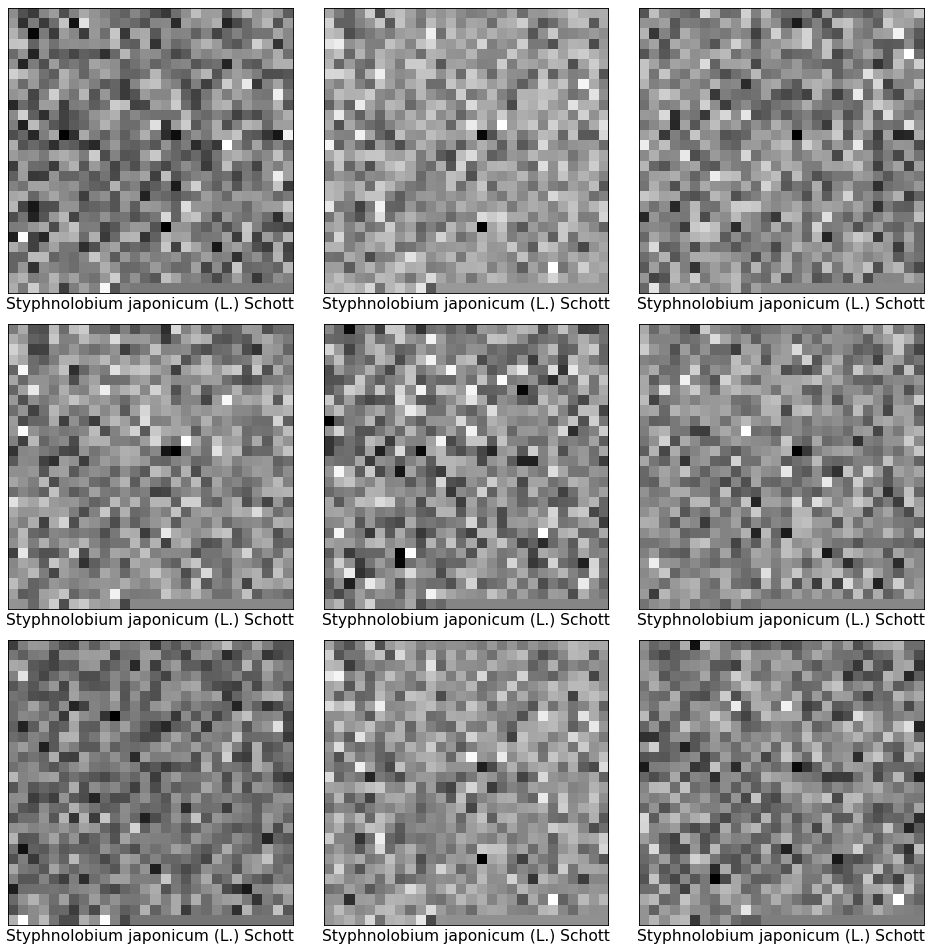

In [11]:
from plantclef.plotting import plot_images_from_embeddings

# Plot DINO image embeddings
plot_images_from_embeddings(
    joined_df, data_col="cls_embedding", image_col="species", grid_size=(3, 3)
)

### train embeddings

In [17]:
# Read and union all Parquet files
from functools import reduce
from pyspark.sql import DataFrame

base_dir = f"{root}/scratch/plantclef/data/embeddings"

# List all directories ending with "_train"
train_dirs = [
    os.path.join(base_dir, d, "data")
    for d in os.listdir(base_dir)
    if d.endswith("_train") and "_subset" not in d
]

# Read all parquet files into a list of DataFrames
dfs = [spark.read.parquet(d) for d in train_dirs]
train_emb_df = reduce(DataFrame.union, dfs)

# Show the data
train_emb_df.printSchema()
train_emb_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)

+--------------------+----------+--------------------+---------+
|          image_name|species_id|       cls_embedding|sample_id|
+--------------------+----------+--------------------+---------+
|51af9088aa5768593...|   1363472|[0.40426737, 0.62...|        7|
|e07b7b3a96ee29ba9...|   1361957|[-1.2018137, 1.03...|        7|
|3714e3500c764a506...|   1397077|[1.0203841, 0.891...|        7|
|5725b5b6a1dcdee37...|   1419917|[0.97013205, 0.02...|        7|
|732761e8fc6366f3e...|   1358748|[-0.2660432, 0.63...|        7|
+--------------------+----------+--------------------+---------+
only showing top 5 rows



In [18]:
# Count the number of rows in the train embedding DataFrame
train_emb_df.count()

1408033

### test embeddings

In [ ]:
# # Path and dataset names
# dino_emb_train = "test_v1/dino/data"

# # Define the GCS path to the embedding files
# dino_gcs_path = f"{gcs_path}/{dino_emb_train}"

# # Read the Parquet file into a DataFrame
# test_dino_df = spark.read.parquet(dino_gcs_path)

# # Show the data
# test_dino_df.show(n=5, truncate=50)

In [ ]:
# from plantclef.plotting import plot_images_from_embeddings

# # Plot test DINO image embeddings
# plot_images_from_embeddings(
#     test_dino_df, data_col="dino_embedding", image_col="image_name", grid_size=(3, 3)
# )